In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [156]:
df = pd.read_excel("../data/titanic3.xls")

### Clean the data
Unclear names are changed.  
Sex is converted into binary values.  
The parents_children and siblings_spouses columns are summarized in the binary alone column (passengers without siblings, spouses, parents, or children are considered to be alone).  
Columns with too many NaN values or meaningless info are dropped.  
The order of the columns is changed for clarity.
It should be noted that class is a categorical column and both sex, survived, and alone are binary columns.

In [157]:
# change names
df = df.rename(columns={'pclass': 'class', 'sibsp': 'siblings_spouses', 'parch': 'parents_children', 'home.dest': 'home_destination'})
# create binary columns for sex and alone
df['sex'] = df['sex'].apply(lambda x: 0 if str(x) == 'male' else 1)
df['alone'] = df.apply(lambda row: 1 if row['parents_children'] == 0 and row['siblings_spouses'] == 0 else 0, axis=1)
# fill null values for age and fare
df['age'].fillna(value=df['age'].mean(), inplace=True)
df['fare'].fillna(value=df['fare'].mean(), inplace=True)
# drop unused columns
df.drop(['cabin', 'boat', 'body', 'ticket', 'name', 'home_destination', 'embarked'], axis=1, inplace=True)
#change order of columns
new_order = ['sex', 'age', 'survived', 'alone', 'siblings_spouses', 'parents_children', 'fare', 'class']
df = df[new_order]

df.head(5)

,sex,age,survived,alone,siblings_spouses,parents_children,fare,class
0,1,29.0000,1,1,0,0,211.3375,1
1,0,0.9167,1,0,1,2,151.5500,1
2,1,2.0000,0,0,1,2,151.5500,1
3,0,30.0000,0,0,1,2,151.5500,1
4,1,25.0000,0,0,1,2,151.5500,1


## Exploratory Data Analysis

<Axes: >

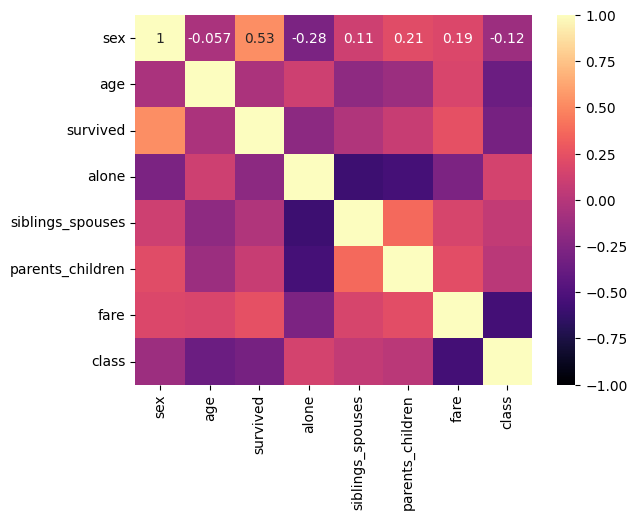

In [158]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, vmin=-1, cmap='magma', annot=True)

In [159]:
corr['survived'].sort_values(ascending=False)

survived            1.000000
sex                 0.528693
fare                0.244208
parents_children    0.082660
siblings_spouses   -0.027825
age                -0.050199
alone              -0.201719
class              -0.312469
Name: survived, dtype: float64

Looking at the correlations we see a negative correlation between alone and both siblings_spouses and parents_children. This is expected as the alone column is based on those. During the training of the models it should be considered to drop the siblings_spouses and parents_children columns.  
There is a negative correlation between fare and class, this is logical as first class tickets are usually sold for a higher fare. Therefore, it should be considered to drop one of these columns during the training of the models (keeping in mind that the fare is more specific and class more normalized).  
We also see a positive correlation between survived and sex. This may indicate that sex may be an important feature in predicting the survival.  
A smaller correlation can be seen between survived and fare (positive), survival and alone (negative), and survival and class (negative). This suggests that people who were alone had a smaller chance of survival. People who paid more/had fancier tickets seemed to have a higher change of survival.

In [160]:
df.describe()

,sex,age,survived,alone,siblings_spouses,parents_children,fare,class
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.355997,29.881135,0.381971,0.603514,0.498854,0.385027,33.295479,2.294882
std,0.478997,12.883199,0.486055,0.489354,1.041658,0.865560,51.738879,0.837836
min,0.000000,0.166700,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,7.895800,2.000000
50%,0.000000,29.881135,0.000000,1.000000,0.000000,0.000000,14.454200,3.000000
75%,1.000000,35.000000,1.000000,1.000000,1.000000,0.000000,31.275000,3.000000
max,1.000000,80.000000,1.000000,1.000000,8.000000,9.000000,512.329200,3.000000


#### Age

<Axes: xlabel='age', ylabel='Count'>

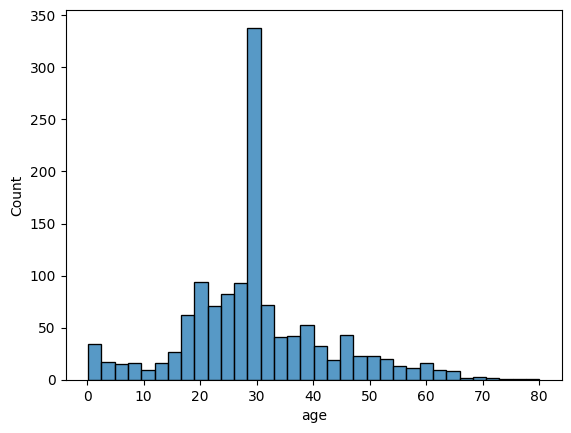

In [161]:
sns.histplot(data=df, x='age')

We see that the age distribution is slightly right skewed with a big peak at 30. We also see an interesting peak at 0 (maybe people are more likely to leave toddlers behind than newborns).

<Axes: xlabel='survived', ylabel='age'>

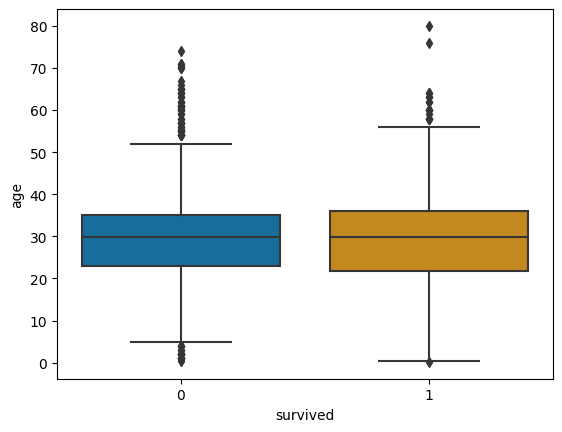

In [162]:
sns.boxplot(data=df, x='survived', y='age', palette='colorblind')

Looking at this boxplot the age distribution does not seem to differ between the people that did and did not survive, this is in line with the low correlation we saw earlier between survived and age.  
But what would happen if we would look at the age as categorical data?

In [163]:
# Categorize age
def age_cat(age):
    if age < 18:
        return 0
    elif 18 < age < 65:
        return 1
    elif age > 65:
        return 2
    else:
        return -1
    
df_age_cat = df.copy()
df_age_cat['age_category'] = df['age'].apply(age_cat)


In [164]:
survived_data = df_age_cat[df_age_cat['survived'] == 1]

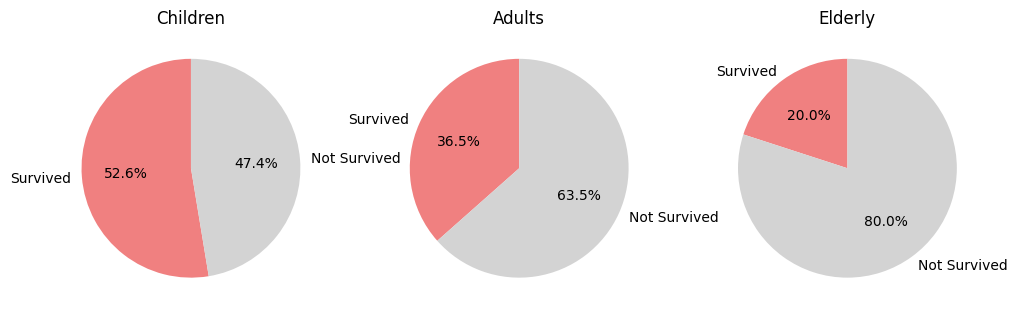

In [165]:
# Define data
labels = ['Survived', 'Not Survived']
colors_female = ['lightcoral', 'lightgray']
colors_male = ['lightblue', 'lightgray']

# Calculate percentages
# Children
children_survived = survived_data[survived_data['age_category'] == 0]
children = df_age_cat[df_age_cat['age_category'] == 0]
percentage_children_survived = children_survived['age_category'].count() / children['age_category'].count()
percentage_children_not_survived = 1 - percentage_children_survived

# Adults
adults_survived = survived_data[survived_data['age_category'] == 1]
adults = df_age_cat[df_age_cat['age_category'] == 1]
percentage_adults_survived = adults_survived['age_category'].count() / adults['age_category'].count()
percentage_adults_not_survived = 1 - percentage_adults_survived

# Elderly
elderly_survived = survived_data[survived_data['age_category'] == 2]
elderly = df_age_cat[df_age_cat['age_category'] == 2]
percentage_elderly_survived = elderly_survived['age_category'].count() / elderly['age_category'].count()
percentage_elderly_not_survived = 1 - percentage_elderly_survived

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Children
ax1.pie([percentage_children_survived, percentage_children_not_survived], labels=labels, colors=colors_female,
        autopct='%1.1f%%', startangle=90)
ax1.set_title('Children')

# Adults
ax2.pie([percentage_adults_survived, percentage_adults_not_survived], labels=labels, colors=colors_female,
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Adults')

# Elderly
ax3.pie([percentage_elderly_survived, percentage_elderly_not_survived], labels=labels, colors=colors_female,
        autopct='%1.1f%%', startangle=90)
ax3.set_title('Elderly')

plt.show()

Here we see that age category seems to affect someone's chance of survival, even though age itself didn't.  
However, if we think back to our histogram, the adults category is way bigger than the other two, let's investigate that further.

In [166]:
df_age_cat.groupby('age_category').size()

age_category
-1      42
 0     154
 1    1103
 2      10
dtype: int64

Here we see that the adults category is disproportionally big, this is a strong indication that this categorization is not going to give us useful insights. We could of course divide the adults group into smaller subgroup, but the high peak at the age of 30 is going to make it that we will continue to have this problem.

#### Fare

<Axes: xlabel='fare', ylabel='Count'>

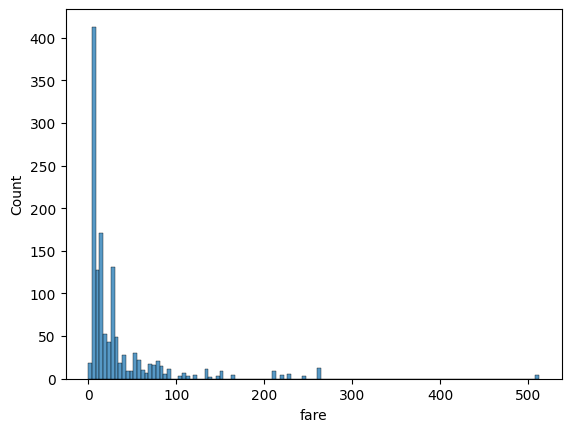

In [167]:
sns.histplot(data=df, x='fare')

We see that the fare distribution is very right skewed: most tickets were cheap, but the few that were expensive were very expensive.  
We see a clear outlier at the value above 500, the values above 200 could also be considered outliers. 

,sex,age,survived,alone,siblings_spouses,parents_children,fare,class
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.355997,29.881135,0.381971,0.603514,0.498854,0.385027,33.295479,2.294882
std,0.478997,12.883199,0.486055,0.489354,1.041658,0.865560,51.738879,0.837836
min,0.000000,0.166700,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,7.895800,2.000000
50%,0.000000,29.881135,0.000000,1.000000,0.000000,0.000000,14.454200,3.000000
75%,1.000000,35.000000,1.000000,1.000000,1.000000,0.000000,31.275000,3.000000
max,1.000000,80.000000,1.000000,1.000000,8.000000,9.000000,512.329200,3.000000


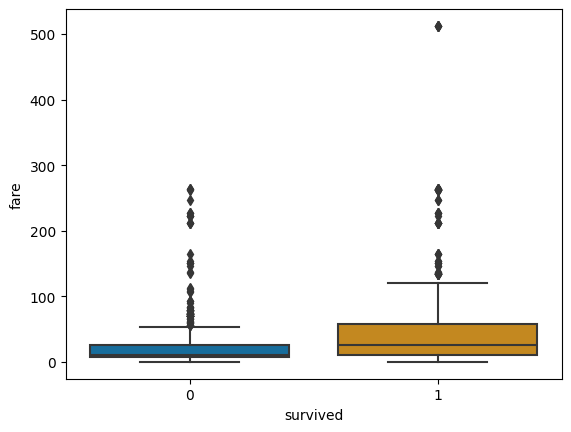

In [168]:
sns.boxplot(data=df, x='survived', y='fare', palette='colorblind')
df.describe()

Based on this plot I am more confident in saying that the outliers are everything above 200, so let's try it again with the outliers removed.

,sex,age,survived,alone,siblings_spouses,parents_children,fare,class
count,1271.000000,1271.000000,1271.000000,1271.00000,1271.000000,1271.000000,1271.000000,1271.000000
mean,0.347758,29.665730,0.372935,0.61133,0.490952,0.365854,26.317613,2.333596
std,0.476446,12.764273,0.483775,0.48764,1.042274,0.847822,29.211513,0.819331
min,0.000000,0.166700,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,22.000000,0.000000,0.00000,0.000000,0.000000,7.895800,2.000000
50%,0.000000,29.881135,0.000000,1.00000,0.000000,0.000000,13.858300,3.000000
75%,1.000000,35.000000,1.000000,1.00000,1.000000,0.000000,29.412500,3.000000
max,1.000000,80.000000,1.000000,1.00000,8.000000,9.000000,164.866700,3.000000


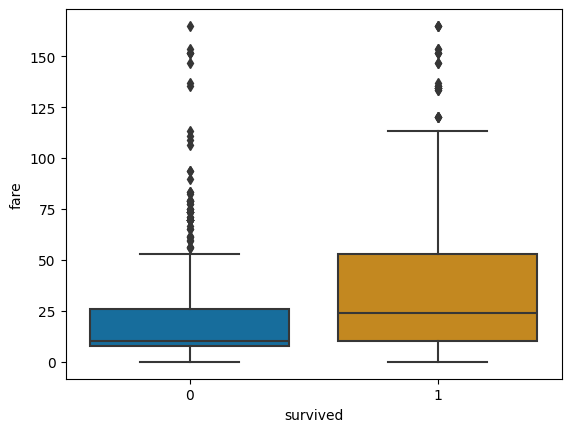

In [169]:
df_edited = df[df['fare'] <= 200]
sns.boxplot(data=df_edited, x='survived', y='fare', palette='colorblind')
df_edited.describe()

Not just is this plot more readable our overall standard deviation for fare went down from 51 to 29 (and the mean from 33 to 26). This is still a big standard deviation but it is definitely an improvement. However, it is dependent on the model wether outliers should be removed, so we will not change this in the main df and leave this to be experimented with during the training of the models.

#### Alone

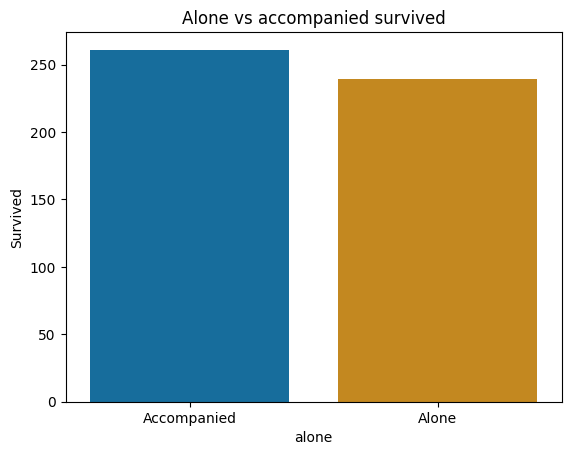

In [170]:
sns.countplot(data=survived_data, x='alone', palette='colorblind')
plt.xticks([0, 1], ['Accompanied', 'Alone'])
plt.ylabel('Survived')
plt.title('Alone vs accompanied survived')
plt.show()

Based on this plot being alone or not seems to have little effect on ones survival chances. People that were not alone seemed to have a slightly higher chance of survival which is in line with what we saw before when looking at the correlation.

#### Sex

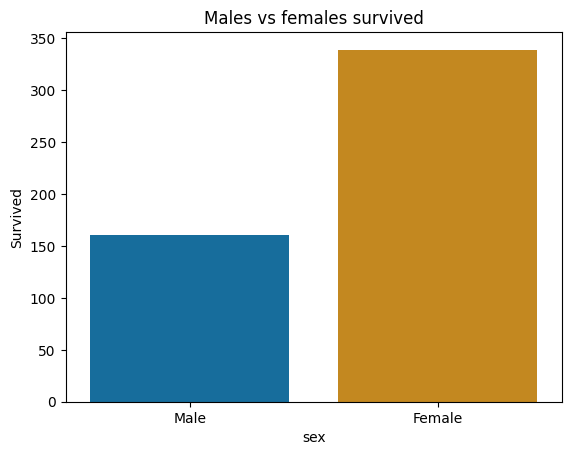

In [171]:
sns.countplot(data=survived_data, x='sex', palette='colorblind')
plt.xticks([0, 1], ['Male', 'Female'])
plt.ylabel('Survived')
plt.title('Males vs females survived')
plt.show()

Based on just this plot sex seems to have a big influence on survival and seems to favour females. This is again in line with what we saw when looking at the correlation.

In summary, during the training of the models the following things should be considered:
- Drop the siblings_spouses and parents_children columns.
- Drop the fare or the class column.
- Remove the outliers from fare (df[df['fare'] <= 200]).  
- Class is a categorical column and both sex, survived, and alone are binary columns